<a href="https://www.kaggle.com/code/martaseidler/most-sold-books-in-the-world?scriptVersionId=161190033" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import charset_normalizer
import fuzzywuzzy
from fuzzywuzzy import process

## Load Data

In [2]:
# check character encoding
with open("/kaggle/input/most-sold-books-in-the-world/Books.csv", 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(10000))

print(result)

{'encoding': 'utf-8', 'language': 'English', 'confidence': 1.0}


In [3]:
df = pd.read_csv('/kaggle/input/most-sold-books-in-the-world/Books.csv')
df.head()

,Book,Author(s),Original language,First published,Approximate sales,Genre
0,A Tale of Two Cities,Charles Dickens,English,1859,>200 million[20][circular reporting?],Historical fiction
1,The Little Prince (Le Petit Prince),Antoine de Saint-Exupéry,French,1943,200 million[21][22],"Fantasy, Children's fiction"
2,Harry Potter and the Philosopher's Stone,J. K. Rowling,English,1997,120 million[23][24],"Fantasy, Children's fiction"
3,And Then There Were None,Agatha Christie,English,1939,100 million[25],Mystery
4,Dream of the Red Chamber (???),Cao Xueqin,Chinese,1791,100 million[26][27],Family saga


## A quick look at the Data

In [4]:
df.sample(5)

,Book,Author(s),Original language,First published,Approximate sales,Genre
245,The Total Woman,Marabel Morgan,English,1974,10 million[172],Erotica
262,Tung Shing (Chinese: ??),"Choi Park Lai's family, among others",Chinese,1891(Only counting versions published by Choi'...,>70 million (Only counting version published b...,Erotica
122,Charlie and the Chocolate Factory,Roald Dahl,English,1964,20 million[118],Children's fantasy novel
228,The Boy in the Striped Pyjamas,John Boyne,English,2006,11 million[156],Dystopian fiction
116,The Good Soldier vejk (Osudy dobrého vojáka ...,Jaroslav Haek,Czech,1923,20 million (printed)[112],Unfinished satirical dark comedy novel


In [5]:
df.describe()

,Book,Author(s),Original language,First published,Approximate sales,Genre
count,264,264,264,264,264,264
unique,170,153,16,98,166,74
top,Tuesdays with Morrie,J. K. Rowling,English,1979,65 million[35],Erotica
freq,3,7,198,10,5,77


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Book               264 non-null    object
 1   Author(s)          264 non-null    object
 2   Original language  264 non-null    object
 3   First published    264 non-null    object
 4   Approximate sales  264 non-null    object
 5   Genre              264 non-null    object
dtypes: object(6)
memory usage: 12.5+ KB


## Preprocessing

In [7]:
# convert column 'Genre' to lower case
df['Genre'] = df['Genre'].str.lower()
# remove trailing white spaces
df['Genre'] = df['Genre'].str.strip()

In [8]:
# chceck genres unique
genres = df['Genre'].unique()
genres.sort()
genres

array(['adventure', 'autobiographical novel',
       'bildungsroman, historical fiction', 'biographical novel',
       "children's fantasy novel", "children's fiction",
       "children's literature", "children's literature, picture book",
       "children's literature, picture book, fiction", "children's novel",
       "children's picture book", 'classic regency novel, romance',
       'coming-of-age', 'coming-of-age murder mystery', 'crime novel',
       'crime thriller novel', 'detective', 'dystopian fiction',
       'erotica', 'essay/literature', 'family saga', 'fantasy',
       "fantasy, children's fiction", 'feminist novel', 'fiction',
       'gothic horror, family saga', 'gothic novel', 'historical fiction',
       'historical fiction, war novel',
       'historical non-fiction, autobiography, memoir, bildungsroman / coming of age, jewish literature',
       'historical novel', 'historical novel, mystery', 'horror',
       'japanese novel', 'magic realism', 'manual', 'memoir', '

In [9]:
# get the top 10 closest matches to "children's literature"
children_matches = fuzzywuzzy.process.extract("children's book", genres, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
children_matches

[("children's picture book", 79),
 ("children's novel", 65),
 ("children's fiction", 61),
 ("children's literature, picture book", 61),
 ("children's literature", 56),
 ("children's literature, picture book, fiction", 53),
 ("children's fantasy novel", 51),
 ("fantasy, children's fiction", 49),
 ('popular science', 40),
 ('science fiction', 40)]

In [10]:
# replace similiar genres
def replace_genres_matches(df, column, string_to_match, min_ratio):
    
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > min_ratio
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches
    rows_with_close_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_close_matches, column] = string_to_match
    
    genres = df['Genre'].unique()
    genres.sort()

In [11]:
replace_genres_matches(df=df, column='Genre', string_to_match="children's book", min_ratio=41)

In [12]:
# get the top 10 closest matches to "young adult"
young_adult_matches = fuzzywuzzy.process.extract("young adult", genres, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
young_adult_matches

[('young adult novel', 79),
 ('young adult fiction', 73),
 ('young adult romantic novel', 59),
 ('young adult historical novel', 56),
 ('philosophical novel, young adult', 52),
 ('coming-of-age', 42),
 ('adventure', 40),
 ('romantic family saga', 39),
 ('dystopian fiction', 36),
 ('family saga', 36)]

In [13]:
replace_genres_matches(df=df, column='Genre', string_to_match="young adult", min_ratio=43)

In [14]:
# get the top 10 closest matches to "romance"
romance_matches = fuzzywuzzy.process.extract("romance", genres, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
romance_matches

[('romance', 100),
 ('romance novel', 70),
 ('romantic novel', 57),
 ('manual', 46),
 ('popular science', 45),
 ('crime novel', 44),
 ('romantic family saga', 44),
 ('erotica', 43),
 ('magic realism', 40),
 ('classic regency novel, romance', 39)]

In [15]:
replace_genres_matches(df=df, column='Genre', string_to_match="romance", min_ratio=47)

In [16]:
# get the top 10 closest matches to "science-fiction"
science_fiction_matches = fuzzywuzzy.process.extract("science-fiction", genres, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
science_fiction_matches

[('science fiction', 100),
 ('science fiction novel', 83),
 ('historical fiction', 67),
 ('fiction', 64),
 ('popular science', 60),
 ('historical fiction, war novel', 56),
 ("children's fiction", 55),
 ('young adult fiction', 53),
 ('bildungsroman, historical fiction', 47),
 ('dystopian fiction', 44)]

In [17]:
replace_genres_matches(df=df, column='Genre', string_to_match="science-fiction", min_ratio=80)

In [18]:
# get the top 10 closest matches to "thriller"
thriller_matches = fuzzywuzzy.process.extract("thriller", genres, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
thriller_matches

[('thriller', 100),
 ('war, thriller', 80),
 ('mystery thriller', 67),
 ('mystery-thriller', 67),
 ('crime thriller novel', 57),
 ('horror', 43),
 ('historical novel', 42),
 ("children's literature", 41),
 ('gothic novel', 40),
 ('mystery', 40)]

In [19]:
replace_genres_matches(df=df, column='Genre', string_to_match="thriller", min_ratio=50)

In [20]:
# get the top 10 closest matches to "historical"
historical_matches = fuzzywuzzy.process.extract("historical", genres, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
historical_matches

[('historical novel', 77),
 ('historical fiction', 71),
 ('historical novel, mystery', 59),
 ('historical fiction, war novel', 53),
 ('young adult historical novel', 53),
 ('biographical novel', 50),
 ('bildungsroman, historical fiction', 48),
 ('erotica', 47),
 ('autobiographical novel', 44),
 ('thriller', 44)]

In [21]:
replace_genres_matches(df=df, column='Genre', string_to_match="historical", min_ratio=52)

In [22]:
# get the top 10 closest matches to "self-help"
self_help_matches = fuzzywuzzy.process.extract("self-help", genres, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
self_help_matches

[('self-help', 100),
 ('novella, self-help', 69),
 ("children's novel", 40),
 ('crime novel', 40),
 ('historical novel', 40),
 ('gothic novel', 38),
 ('biographical novel', 37),
 ("children's fantasy novel", 36),
 ('historical novel, mystery', 36),
 ('novel, tragedy', 36)]

In [23]:
replace_genres_matches(df=df, column='Genre', string_to_match="self-help", min_ratio=68)

In [24]:
# chceck genres unique
genres = df['Genre'].unique()
genres.sort()
genres

array(['adventure', 'autobiographical novel',
       'bildungsroman, historical fiction', 'biographical novel',
       "children's book", 'classic regency novel, romance',
       'coming-of-age', 'coming-of-age murder mystery', 'crime novel',
       'detective', 'dystopian fiction', 'erotica', 'essay/literature',
       'family saga', 'fantasy', 'feminist novel', 'fiction',
       'gothic horror, family saga', 'gothic novel', 'historical',
       'historical non-fiction, autobiography, memoir, bildungsroman / coming of age, jewish literature',
       'horror', 'japanese novel', 'magic realism', 'manual', 'memoir',
       'mystery', 'new-age spiritual novel', 'novel', 'novel, tragedy',
       'picaresque novel, bildungsroman, satire, robinsonade',
       'popular science',
       'popular science, anthropology, astrophysics, cosmology, philosophy, history',
       'pregnancy guide', 'romance', 'romantic family saga',
       'science-fiction', 'self-help',
       'self-help, motivational

In [25]:
df['Genre'] = df['Genre'].replace(['young adult novel, adventure, dystopian, science fiction', 'young adult novel, adventure, war, science fiction, action thriller'], 'young adult')
df['Genre'] = df['Genre'].replace(['popular science, anthropology, astrophysics, cosmology, philosophy, history'], 'popular science')
df['Genre'] = df['Genre'].replace(['detective', 'mystery'], 'crime novel')
df['Genre'] = df['Genre'].replace(['coming-of-age', 'coming-of-age murder mystery'], 'young adult')
df['Genre'] = df['Genre'].replace(['autobiographical novel', 'biographical novel', 'memoir','historical non-fiction, autobiography, memoir, bildungsroman / coming of age, jewish literature','semi-autobiographical novel'],'biography')
df['Genre'] = df['Genre'].replace(['romantic family saga', 'classic regency novel, romance'], 'romance')
df['Genre'] = df['Genre'].replace(['unfinished satirical dark comedy novel'], 'comedy')
df['Genre'] = df['Genre'].replace(['bildungsroman, historical fiction'], 'historical')
df['Genre'] = df['Genre'].replace(['picaresque novel, bildungsroman, satire, robinsonade'], 'adventure')
df['Genre'] = df['Genre'].replace(['gothic horror, family saga'], 'horror')
df['Genre'] = df['Genre'].replace(['magic realism'], 'fiction')
df['Genre'] = df['Genre'].replace(['novel, tragedy', 'gothic novel', 'feminist novel', 'japanese novel', 'new-age spiritual novel', 'socialist realist novel', 'southern gothic, bildungsroman'], 'novel')
df['Genre'] = df['Genre'].replace(['self-help, motivational, business fable, psychology, leadership, parable', 'self-help', 'social science, anthropology, psychology', 'sexology', 'manual', 'pregnancy guide'], 'guide')


In [26]:
# chceck genres unique
genres = df['Genre'].unique()
genres.sort()
genres

array(['adventure', 'biography', "children's book", 'comedy',
       'crime novel', 'dystopian fiction', 'erotica', 'essay/literature',
       'family saga', 'fantasy', 'fiction', 'guide', 'historical',
       'horror', 'novel', 'popular science', 'romance', 'science-fiction',
       'thriller', 'travel literature', 'young adult'], dtype=object)

In [27]:
df['Genre'].value_counts()

Genre
erotica              77
children's book      29
historical           26
science-fiction      26
dystopian fiction    18
young adult          17
novel                15
guide                11
fantasy               8
thriller              7
romance               5
horror                5
biography             5
fiction               4
crime novel           3
adventure             2
popular science       2
family saga           1
essay/literature      1
travel literature     1
comedy                1
Name: count, dtype: int64

In [28]:
df.head()

,Book,Author(s),Original language,First published,Approximate sales,Genre
0,A Tale of Two Cities,Charles Dickens,English,1859,>200 million[20][circular reporting?],historical
1,The Little Prince (Le Petit Prince),Antoine de Saint-Exupéry,French,1943,200 million[21][22],children's book
2,Harry Potter and the Philosopher's Stone,J. K. Rowling,English,1997,120 million[23][24],children's book
3,And Then There Were None,Agatha Christie,English,1939,100 million[25],crime novel
4,Dream of the Red Chamber (???),Cao Xueqin,Chinese,1791,100 million[26][27],family saga


In [29]:
df['Approximate sales (mln)'] = df['Approximate sales'].str.extract('(\d+)',expand=False).astype('int32')
df = df.drop('Approximate sales', axis=1)
df.head()

,Book,Author(s),Original language,First published,Genre,Approximate sales (mln)
0,A Tale of Two Cities,Charles Dickens,English,1859,historical,200
1,The Little Prince (Le Petit Prince),Antoine de Saint-Exupéry,French,1943,children's book,200
2,Harry Potter and the Philosopher's Stone,J. K. Rowling,English,1997,children's book,120
3,And Then There Were None,Agatha Christie,English,1939,crime novel,100
4,Dream of the Red Chamber (???),Cao Xueqin,Chinese,1791,family saga,100


In [30]:
df.loc[df['First published'] == '1925\x961929']

,Book,Author(s),Original language,First published,Genre,Approximate sales (mln)
190,The Story of My Experiments with Truth (??????...,Mohandas Karamchand Gandhi,Gujarati,19251929,erotica,10
258,The Story of My Experiments with Truth (??????...,Mohandas Karamchand Gandhi,Gujarati,19251929,erotica,10


In [31]:
df["First published"] = df["First published"].str.slice(0,4).astype("int32")

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Book                     264 non-null    object
 1   Author(s)                264 non-null    object
 2   Original language        264 non-null    object
 3   First published          264 non-null    int32 
 4   Genre                    264 non-null    object
 5   Approximate sales (mln)  264 non-null    int32 
dtypes: int32(2), object(4)
memory usage: 10.4+ KB


## Data Visualization

In [33]:
sns.set_palette('deep')
sns.set_style("darkgrid",{"grid.color": ".6", "grid.linestyle": ":"})

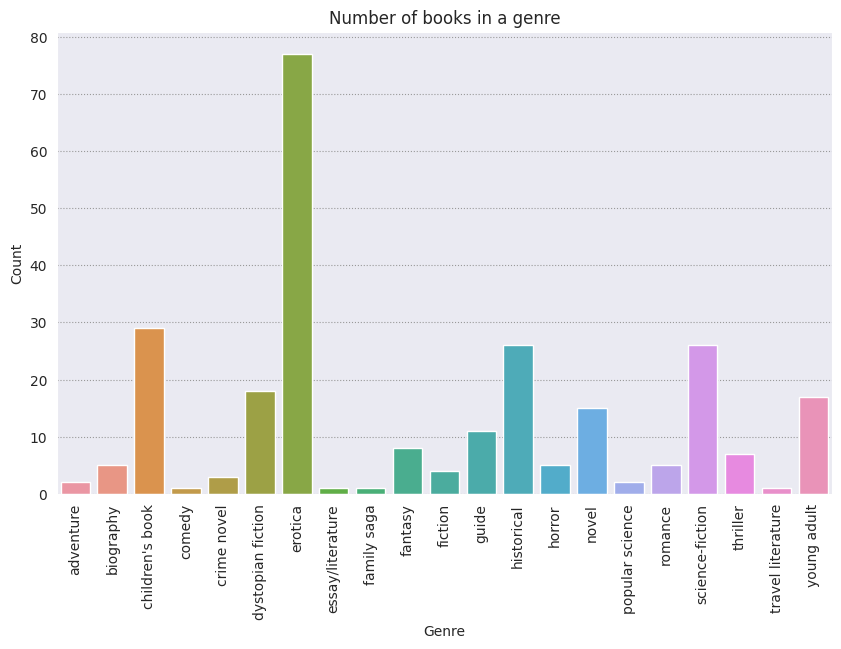

In [34]:
df_copy = df.sort_values('Genre')
plt.figure(figsize=(10, 6))
sns.countplot(x='Genre', data=df_copy)
plt.title('Number of books in a genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation ='vertical')
plt.show()

In [35]:
best_authors = pd.DataFrame(df['Author(s)'].value_counts().head(7))
best_authors

,count
Author(s),
J. K. Rowling,7
Roald Dahl,5
Michael Ende,5
E. L. James,5
Erskine Caldwell,5
Ken Follett,5
Albert Camus,4


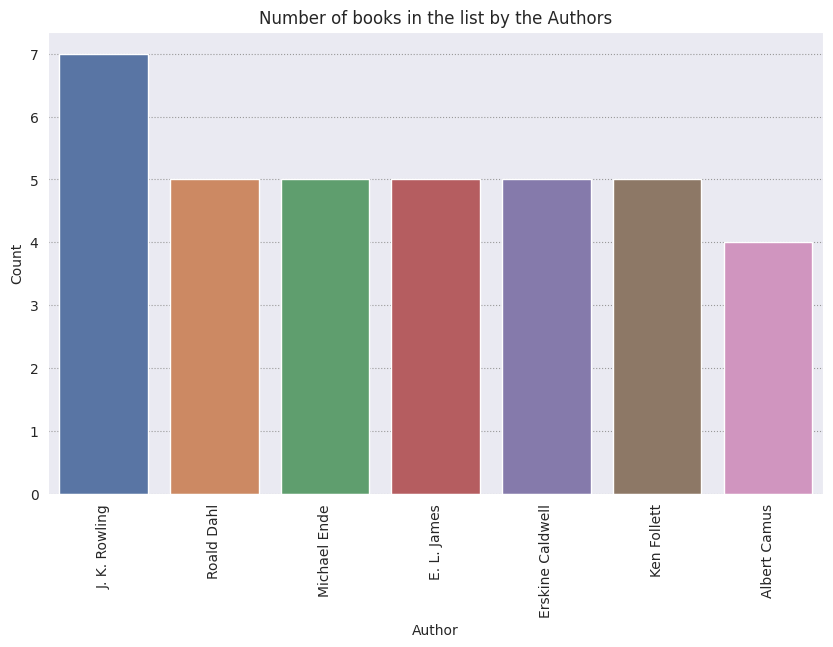

In [36]:
plt.figure(figsize=(10, 6))
sns.barplot(x=best_authors.index, y=best_authors['count'])
plt.title('Number of books in the list by the Authors')
plt.xlabel('Author')
plt.ylabel('Count')
plt.xticks(rotation ='vertical')
plt.show()

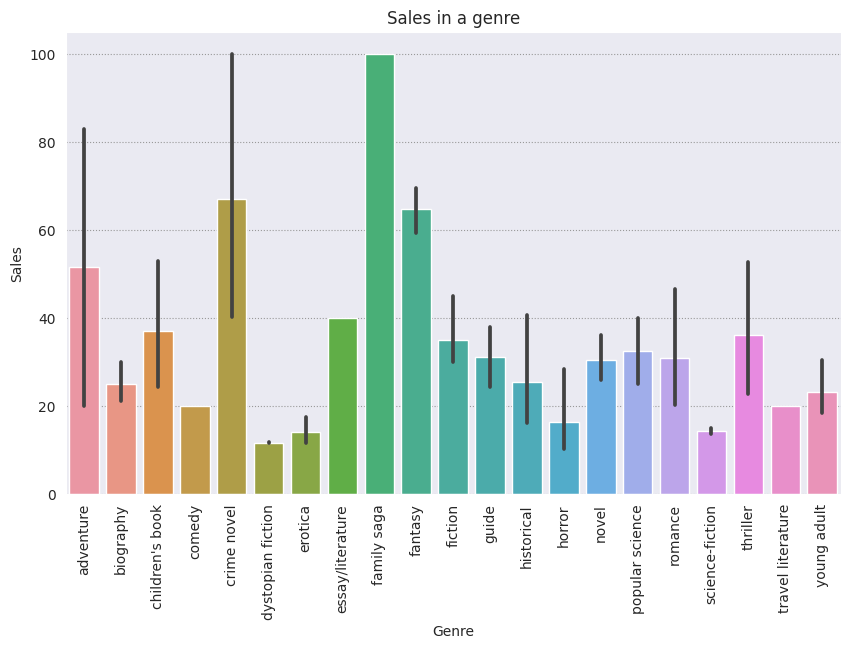

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Genre'].sort_values(), y=df['Approximate sales (mln)'])
plt.title('Sales in a genre')
plt.xlabel('Genre')
plt.ylabel('Sales')
plt.xticks(rotation ='vertical')
plt.show()

In [38]:
best_sales_authors = df.groupby(["Author(s)"])["Approximate sales (mln)"].sum()
best_sales_authors = best_sales_authors.sort_values(ascending=False).head(15)
best_sales_authors

Author(s)
J. K. Rowling                           522
Antoine de Saint-Exupéry                200
Charles Dickens                         200
Dan Brown                               149
Agatha Christie                         100
Cao Xueqin                              100
J. R. R. Tolkien                        100
Roald Dahl                               99
H. Rider Haggard                         83
Various authors                          82
Ved Prakash Sharma                       80
General Mills staff                      75
Michael Ende                             74
Choi Park Lai's family, among others     70
Suzanne Collins                          70
Name: Approximate sales (mln), dtype: int32

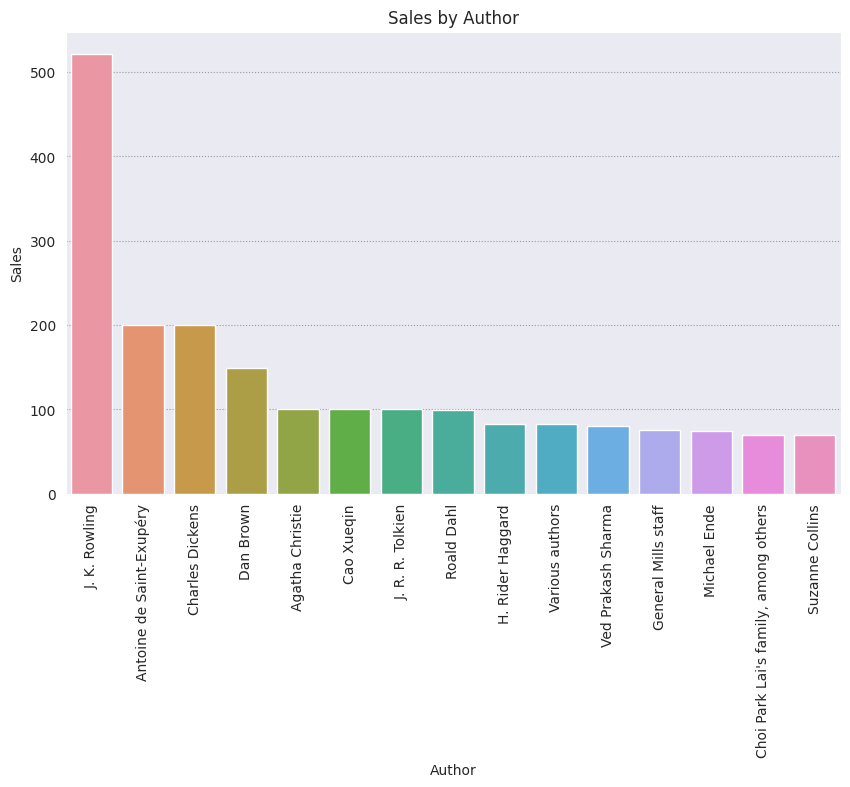

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(x=best_sales_authors.index, y=best_sales_authors)
plt.title('Sales by Author')
plt.xlabel('Author')
plt.ylabel('Sales')
plt.xticks(rotation ='vertical')
plt.show()

In [40]:
language_group = df.groupby(["Original language"])["Approximate sales (mln)"].sum()
language_group = language_group.sort_values(ascending=False).head(15)
language_group

Original language
English       4811
French         289
Chinese        230
German         193
Russian        163
Italian        149
Spanish        115
Japanese       113
Hindi           80
Portuguese      65
Norwegian       60
Swedish         50
Dutch           35
Czech           20
Gujarati        20
Name: Approximate sales (mln), dtype: int32

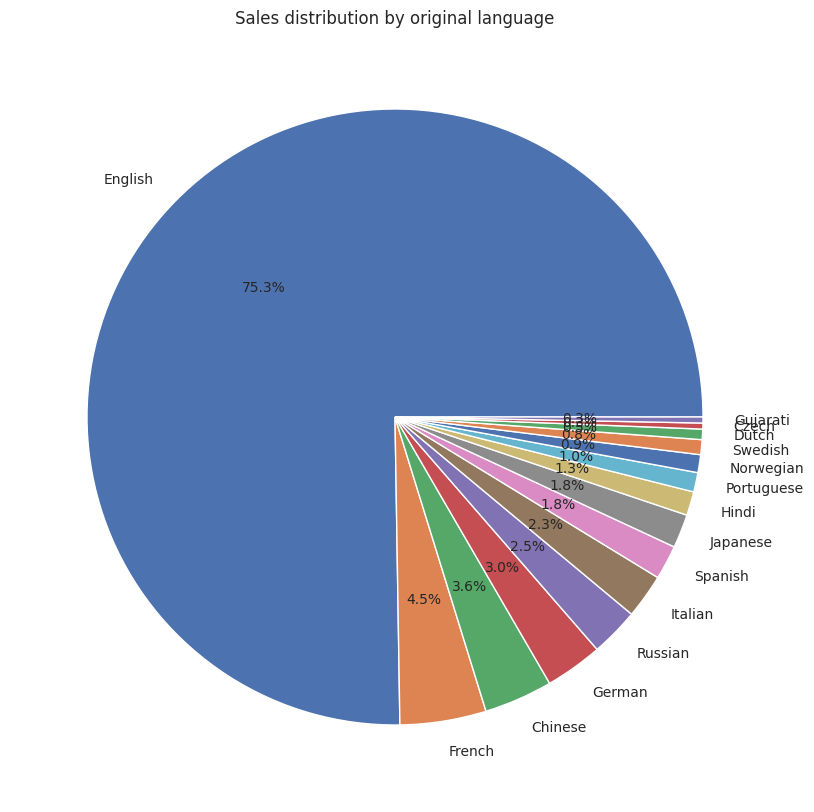

In [41]:
plt.figure(figsize=(10, 10))
plt.pie(language_group, labels=language_group.index, autopct='%1.1f%%')
plt.title("Sales distribution by original language")
plt.show()

In [42]:
first_published_group = df.groupby(["First published"])["Approximate sales (mln)"].sum()
first_published_group = first_published_group.sort_index(ascending=True)
first_published_group

First published
1304     22
1788     25
1791    100
1813     20
1859    200
       ... 
2012     87
2014     45
2015     23
2016     20
2018     96
Name: Approximate sales (mln), Length: 96, dtype: int32

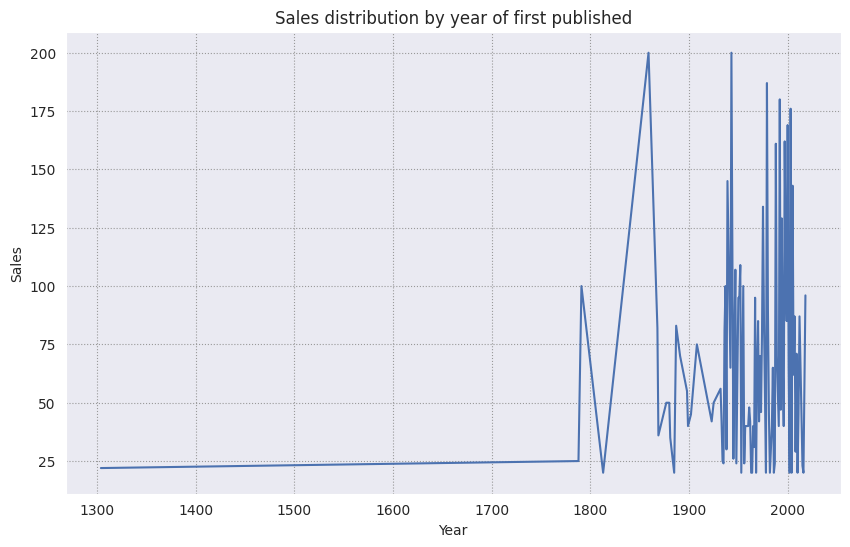

In [43]:
plt.figure(figsize=(10,6))
plt.plot(first_published_group)
plt.title("Sales distribution by year of first published")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.show()

In [44]:
first_published_1750_group = df.groupby(["First published"])["Approximate sales (mln)"].sum()
first_published_1750_group = first_published_1750_group.sort_index(ascending=True)
first_published_1750_group.drop(1304, axis='index', inplace=True)
first_published_1750_group

First published
1788     25
1791    100
1813     20
1859    200
1868     82
       ... 
2012     87
2014     45
2015     23
2016     20
2018     96
Name: Approximate sales (mln), Length: 95, dtype: int32

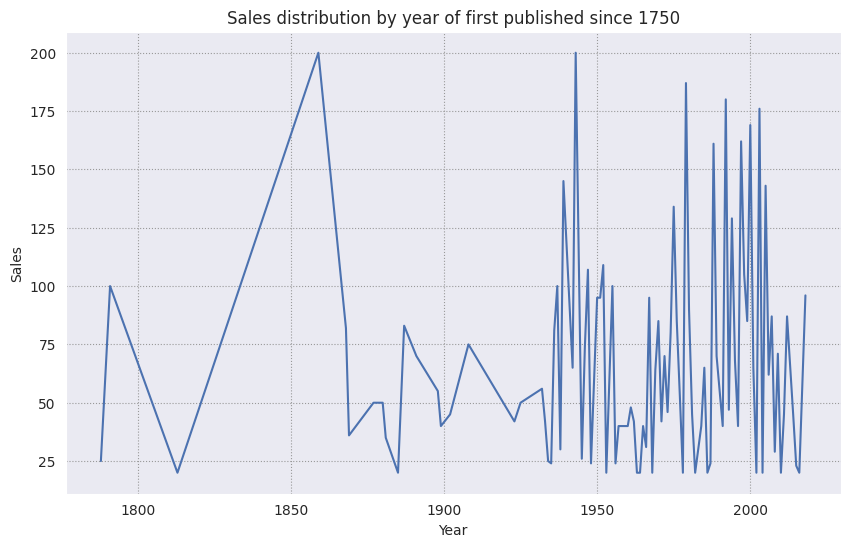

In [45]:
plt.figure(figsize=(10,6))
plt.plot(first_published_1750_group)
plt.title("Sales distribution by year of first published since 1750")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.show()